In [ ]:
import pandas as pd
import numpy as np
import nltk

from nltk.tokenize import word_tokenize
import re

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout, SpatialDropout1D
from keras.layers import Conv1D , GlobalMaxPooling1D,MaxPooling1D,Conv2D
from keras.callbacks import ModelCheckpoint

In [ ]:
num_classes = 3

embed_num_dims = 200
max_seq_len = 1000


class_names = ['Positive', 'Negative','Neutral']

In [ ]:
def shuffle(df, n=1, axis=0):
    df = df.copy()
    for _ in range(n):
      df.apply(np.random.shuffle, axis=axis)
    return df

In [ ]:
data= pd.read_excel('/content/daraz.xlsx')

In [ ]:
print(data.columns)

Index(['Sl', 'Text', 'Categore', 'Polarity'], dtype='object')


In [ ]:
data.isnull().values.any()

True

In [ ]:
data.dropna(subset = ["Text","Polarity"], inplace =True )

In [ ]:
data.isnull().values.any()

True

<ipython-input-11-7d7d34880f46>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Polarity', data=data, palette=original_colors)


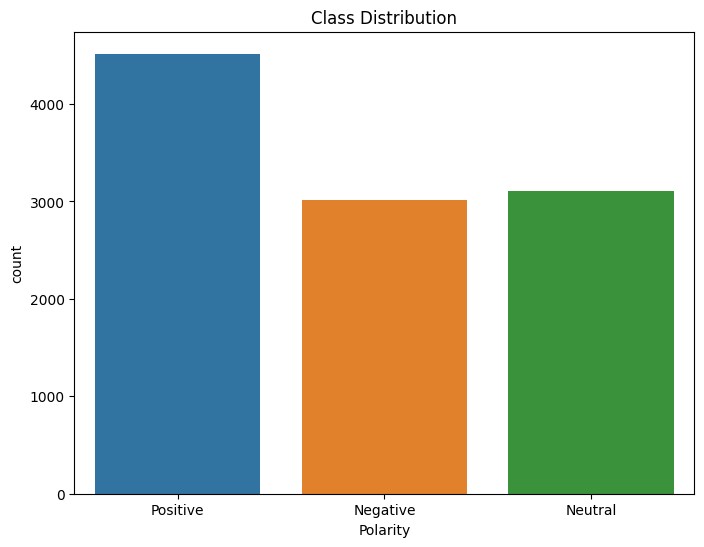

In [ ]:
#import seaborn as sns
#sns.countplot(x='Polarity', data=data)
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color palette with three colors for the original dataset
original_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Polarity', data=data, palette=original_colors)
plt.title('Class Distribution')
# Show the plots
plt.show()

In [ ]:
data.sort_values(by='Polarity', axis=0, inplace=True)

data.set_index(keys=['Polarity'], drop=False,inplace=True)
Categorys=data['Polarity'].unique().tolist()

In [ ]:
positives = shuffle(data.loc[data.Polarity=='Positive'])
negatives = shuffle(data.loc[data.Polarity=='Negative'])
neutrals = shuffle(data.loc[data.Polarity=='Neutral'])

/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:814: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)
/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:814: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)
/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:814: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)
/usr/local/lib/python3.10

In [ ]:
positives_train = positives.iloc[0:int(positives.shape[0]*1)]
positives_test = positives.iloc[0:int(positives.shape[0]*1)]

negatives_train = negatives.iloc[0:int(negatives.shape[0]*1)]
negatives_test = negatives.iloc[0:int(negatives.shape[0]*1)]

neutrals_train = neutrals.iloc[0:int(neutrals.shape[0]*1)]
neutrals_test = neutrals.iloc[0:int(neutrals.shape[0]*1)]

data_train = pd.concat([positives_train, negatives_train, neutrals_train])
data_test = pd.concat([positives_test, negatives_test, neutrals_test])

print(data_train.shape)
print(data_test.shape)

(10637, 4)
(10637, 4)


In [ ]:
X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Polarity
y_test = data_test.Polarity

data = pd.concat([data_train, data_test], ignore_index=True)

print(data['Polarity'].value_counts())
data.head(10)

Polarity
Positive    9032
Neutral     6212
Negative    6030
Name: count, dtype: int64


,Sl,Text,Categore,Polarity
0,3501,দারুন প্যান্ট সবাই নিতে পারেন,phone,Positive
1,601,অসংখ্য ধন্যবাদ সেলার ভাই 🥰🥰\nএকটা কলম গিফট পেয়...,phone,Positive
2,144,varryGood product...❤️\n100/100% Original prod...,phone,Positive
3,2236,"সঠিক পণ্য সঠিক সময়ে হাতে পেয়েছি ,,\nধন্যবাদ আপ...",phone,Positive
4,2343,দ্রুত ডেলিভারী পেয়েছি.. অরিজিনাল প্রোডাক্ট...,Shaver & Trimmer,Positive
5,2383,১০ দিনের মতো হয়ছে।ভালোই চলতেছে। ৭ থেকে ৮ ঘন্টা...,phone,Positive
6,4100,খুবই ভালো একটি পন্য পেয়েছি।\nধন্যবাদ দারাজ।,smart phone,Positive
7,469,"অর্ডার করার পরের দিন এটি ডেলিভারি পেয়েছিলাম, ...",phone,Positive
8,3881,বেশ কয়েকদিন ইউজ করার পরে রিভিউ দিলাম প্রোডাক্...,Bluetooth Headphone,Positive
9,4076,অনেক কমে পেয়েছি। মেয়াদ নিয়ে টেনশন নেই ২০২৪/১২/...,phone,Positive


In [ ]:
print(data.dtypes)


Sl           int64
Text        object
Categore    object
Polarity    object
dtype: object


In [ ]:
print(data_train.Polarity.value_counts())
print(data_test.Polarity.value_counts())

Polarity
Positive    4516
Neutral     3106
Negative    3015
Name: count, dtype: int64
Polarity
Positive    4516
Neutral     3106
Negative    3015
Name: count, dtype: int64


In [ ]:
def clean_text(data):
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = word_tokenize(data)

    return data

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
from nltk.tokenize import word_tokenize
def remove_emojis(text):
    # Emoji pattern: Matches any unicode emoji
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F1E0-\U0001F1FF]|[\U00002702-\U000027B0]|[\U000024C2-\U0001F251]", flags=re.UNICODE)
    english_pattern = re.compile('[a-zA-Z0-9]+', flags=re.I)
    text = english_pattern.sub(r'', text)
    return emoji_pattern.sub(r'', text)

def clean_text(data):
    # Check if data is None or NaN, and convert to an empty string
    if data is None or pd.isnull(data):
        data = ''

    # Convert data to string if it's not already
    if not isinstance(data, str):
        data = str(data)

    # Text cleaning operations
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = remove_emojis(data)
    data_tokens = word_tokenize(data)
    cleaned_data = ' '.join(data_tokens)

    return cleaned_data
def remove_punctuations(my_str):
    # Define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # Display the unpunctuated string
    return no_punct

def preprocessing(text):
    # Preprocess text
    text = clean_text(text)
    text = remove_punctuations(text)
    return text

texts = [clean_text(text) for text in data.Text]
texts_train = [clean_text(text) for text in X_train]
texts_test = [clean_text(text) for text in X_test]

print(texts_train[5])

১০ দিনের মতো হয়ছে।ভালোই চলতেছে। ৭ থেকে ৮ ঘন্টা ব্যাকআপ পেয়েছি।জেনুইন প্রডাক্ট। সবমিলিয়ে ঠিক আছে।


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 15255


In [ ]:
print("Sentence :--> \n")
print(texts_train[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequence_train[2])+"\n")

Sentence :--> 

... / % . .. .

Sentence Tokenized and Converted into Sequence :--> 

[]



In [ ]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00


In [ ]:
from keras_preprocessing.sequence import pad_sequences

In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,   96,   23,   50],
       [   0,    0,    0, ..., 1218, 2254,  276],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,  403,  909,   99],
       [   0,    0,    0, ..., 1519, 1520,  858],
       [   0,    0,    0, ...,  284, 7920, 7921]], dtype=int32)

In [ ]:
encoding = {
    'Positive': 0,
    'Negative': 1,
    'Neutral': 2
}

y_train = [encoding[x] for x in data_train.Polarity]
y_test = [encoding[x] for x in data_test.Polarity]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
import urllib.request
import zipfile
import os

GLOVE_DIM = 200
fname = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'

# Debugging output
print('Checking if file exists:', fname)

# Check if the file exists, if not, download and extract it
if not os.path.isfile(fname):
    print('Downloading word vectors...')
    try:
        # Try downloading from a different URL
        urllib.request.urlretrieve('http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip', 'glove.twitter.27B.zip')
        print('Unzipping...')
        with zipfile.ZipFile('glove.twitter.27B.zip', 'r') as zip_ref:
            zip_ref.extractall('')
        print('Done.')

        # Remove the downloaded zip file
        os.remove('glove.twitter.27B.zip')

    except Exception as e:
        print('Error occurred while downloading:', e)

# Now you can use the downloaded GloVe word vectors file


Checking if file exists: glove.twitter.27B.200d.txt
Unzipping...
Done.


In [ ]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open(glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

NB_WORDS = vocab_size
MAX_LEN = max_seq_len

emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))
for w, i in tokenizer.word_index.items():
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        if vect is not None:
          emb_matrix[i] = vect
    else:
        break

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, SpatialDropout1D, Dropout, Dense

model = Sequential()
model.add(Embedding(vocab_size,
                    GLOVE_DIM,
                    input_length=max_seq_len,
                    weights=[emb_matrix],
                    trainable=False))

model.add(SpatialDropout1D(0.2))

model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 200)         3051200   
                                                                 
 spatial_dropout1d (Spatial  (None, 1000, 200)         0         
 Dropout1D)                                                      
                                                                 
 gru (GRU)                   (None, 1000, 64)          51072     
                                                                 
 dropout (Dropout)           (None, 1000, 64)          0         
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
from time import time
t1 = time()

batch_size = 256
epochs = 70

print(X_test_pad.shape)
print(y_test.shape)

print(X_train_pad.shape)
print(y_train.shape)

(10637, 1000)
(10637, 3)
(10637, 1000)
(10637, 3)


In [ ]:
hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad, y_test))

Epoch 1/70
42/42 [==============================] - 15s 164ms/step - loss: 1.0198 - accuracy: 0.4878 - val_loss: 0.9272 - val_accuracy: 0.5679
Epoch 2/70
42/42 [==============================] - 5s 131ms/step - loss: 0.9359 - accuracy: 0.5619 - val_loss: 0.8825 - val_accuracy: 0.5980
Epoch 3/70
42/42 [==============================] - 6s 132ms/step - loss: 0.8993 - accuracy: 0.5922 - val_loss: 0.8536 - val_accuracy: 0.6235
Epoch 4/70
42/42 [==============================] - 7s 162ms/step - loss: 0.8818 - accuracy: 0.5996 - val_loss: 0.8382 - val_accuracy: 0.6260
Epoch 5/70
42/42 [==============================] - 7s 162ms/step - loss: 0.8687 - accuracy: 0.6045 - val_loss: 0.8500 - val_accuracy: 0.6254
Epoch 6/70
42/42 [==============================] - 7s 162ms/step - loss: 0.8666 - accuracy: 0.6095 - val_loss: 0.8132 - val_accuracy: 0.6294
Epoch 7/70
42/42 [==============================] - 6s 136ms/step - loss: 0.8447 - accuracy: 0.6221 - val_loss: 0.7971 - val_accuracy: 0.6427
Epoch

In [ ]:
t2 = time()
t_delta = round(t2-t1,2)
print(t_delta)

506.4


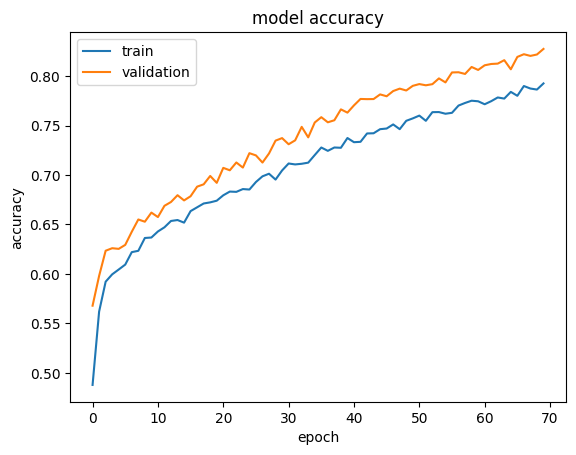

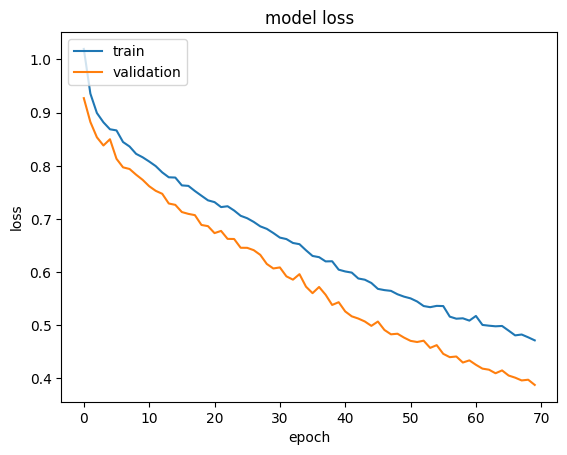

In [ ]:
# Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

333/333 [==============================] - 9s 24ms/step


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
print(precision_recall_fscore_support(data_test.Polarity, predictions, average='micro'))
print(precision_recall_fscore_support(data_test.Polarity, predictions, average='macro'))
print(precision_recall_fscore_support(data_test.Polarity, predictions, average='weighted'))

(0.8274889536523455, 0.8274889536523455, 0.8274889536523455, None)
(0.8431121323757981, 0.8153898663113509, 0.8254670928122124, None)
(0.8341976895362692, 0.8274889536523455, 0.8269418325162032, None)



F1 Score: 82.75


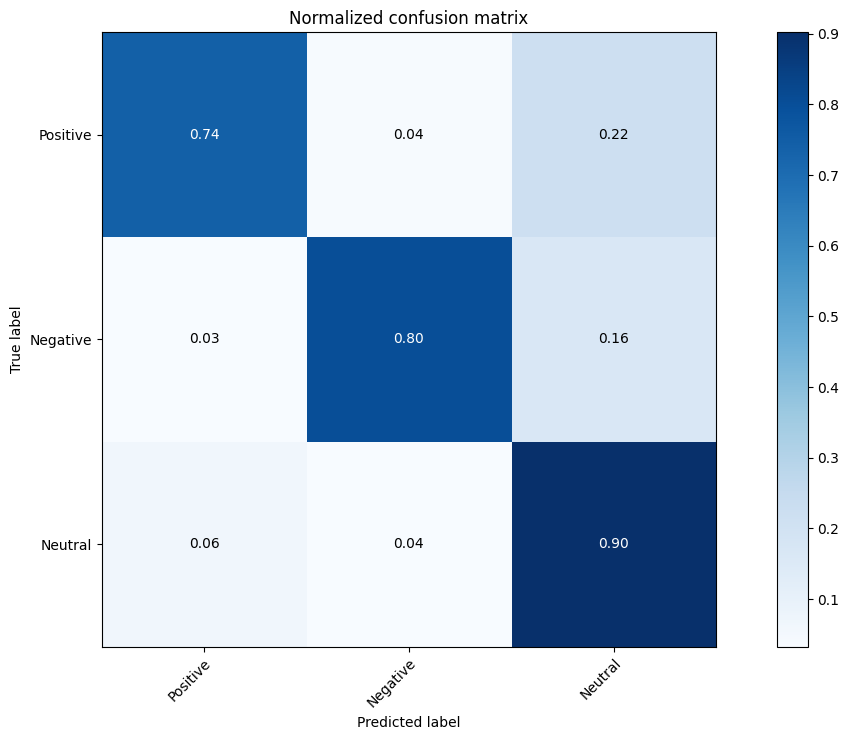

Message: খুবই ভালো একটি পন্য পেয়েছি।
ধন্যবাদ দারাজ।
Predicted: Positive


In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("\nF1 Score: {:.2f}".format(f1_score(data_test.Polarity, predictions, average='micro') * 100))

plot_confusion_matrix(data_test.Polarity, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print('Message: {}\nPredicted: {}'.format(X_test[6], predictions[6]))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(data_test.Polarity, predictions)))

print('Micro Precision: {:.2f}'.format(precision_score(data_test.Polarity, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(data_test.Polarity, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(data_test.Polarity, predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(data_test.Polarity, predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(data_test.Polarity, predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(data_test.Polarity, predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(data_test.Polarity, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(data_test.Polarity, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(data_test.Polarity, predictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(data_test.Polarity, predictions, target_names=class_names))


Accuracy: 0.83

Micro Precision: 0.83
Micro Recall: 0.83
Micro F1-score: 0.83

Macro Precision: 0.84
Macro Recall: 0.82
Macro F1-score: 0.83

Weighted Precision: 0.83
Weighted Recall: 0.83
Weighted F1-score: 0.83

Classification Report

              precision    recall  f1-score   support

    Positive       0.85      0.74      0.79      3015
    Negative       0.90      0.80      0.85      3106
     Neutral       0.78      0.90      0.83      4516

    accuracy                           0.83     10637
   macro avg       0.84      0.82      0.83     10637
weighted avg       0.83      0.83      0.83     10637



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, log_loss, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn import metrics

cm = confusion_matrix(data_test.Polarity, predictions)

TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

In [ ]:
from sklearn import metrics
print('Sensitivity : ', TP/(TP+FN))
print('Specificity : ', TN/(TN+FP))
print('false positive rate : ', FP/(FP+TN))
print('false negative rate : ', FN/(FN+TP))
print('Negative Predictive Value : ', TN/(TN+FN))
print('False Discovery rate : ', FP/(TP+FP))


Sensitivity :  0.9563729683490163
Specificity :  0.9548065875143623
false positive rate :  0.045193412485637685
false negative rate :  0.04362703165098375
Negative Predictive Value :  0.9606936416184971
False Discovery rate :  0.05012744265080714


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,model.predict(X_test_pad)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,model.predict(X_test_pad)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,model.predict(X_test_pad))))
print('Cohen_Kappa_Score:', cohen_kappa_score(data_test.Polarity, predictions))

333/333 [==============================] - 12s 35ms/step
Mean Absolute Error: 0.15485269
333/333 [==============================] - 8s 23ms/step
Mean Squared Error: 0.075227834
333/333 [==============================] - 18s 53ms/step
Root Mean Squared Error: 0.27427694
Cohen_Kappa_Score: 0.732435074889384
